In [100]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.io import read_image
import os
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model
from torch.utils.data import DataLoader
import time

In [101]:
digits = np.loadtxt('mfeat-pix.txt', usecols=range(240))

In [102]:
digits.size

480000

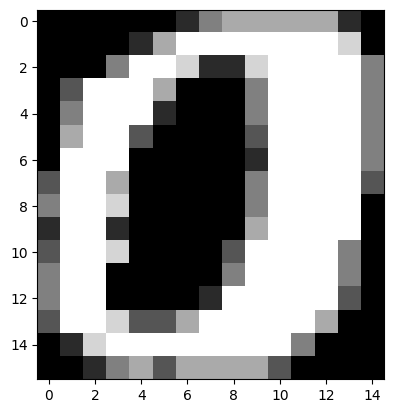

In [103]:
plt.imshow(digits[1].reshape(16,15), cmap='gray')

In [104]:
x_train = np.empty([1000, 240])
y_train = []
x_test = np.empty([1000, 240])
y_test = []
for d in range(10):
    for i in range(100):
        x_train[d*100 + i] = digits[d*200 + i]
        x_test[d*100 + i] = digits[100 + d*200 + i]
    y_train = np.concatenate((y_train, np.full(100, d)))
    y_test = np.concatenate((y_test, np.full(100, d)))

x_train = x_train / x_train.max()
x_test = x_test / x_test.max()

In [105]:
lr = sklearn.linear_model.LogisticRegression(solver='saga', tol=0.1)
lr = lr.fit(x_train, y_train)

print(f'train: {lr.score(x_train, y_train)}')
print(f'test: {lr.score(x_test, y_test)}')

train: 0.983
test: 0.953


In [106]:
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Train: X=%s, y=%s' % (x_test.shape, y_test.shape))

Train: X=(1000, 240), y=(1000,)
Train: X=(1000, 240), y=(1000,)


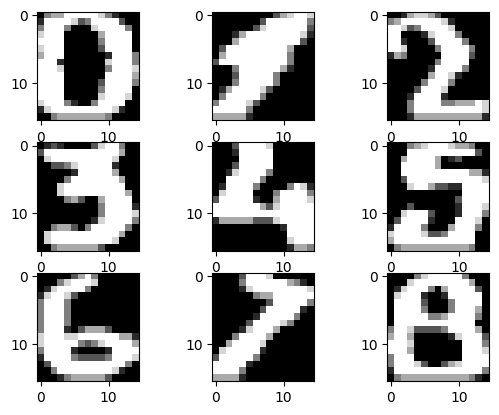

In [107]:
for i in range(9):
 # define subplot
 plt.subplot(330 + 1 + i)
 # plot raw pixel data
 plt.imshow(x_train[100*i].reshape(16,15), cmap='gray')
# show the figure
plt.show()

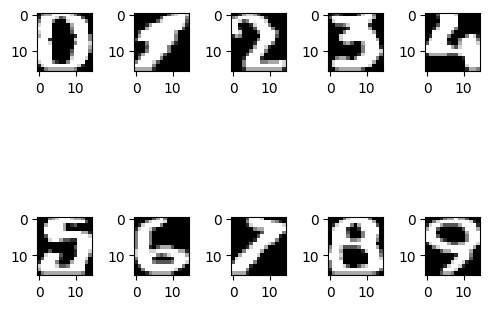

In [108]:
fig, axes = plt.subplots(2, 5, figsize=(5, 5))
for i in range(10):
    row = i // 5
    col = i % 5
    axes[row, col].imshow(x_train[100 * i].reshape(16, 15), cmap='gray')
plt.tight_layout()
plt.show()

In [109]:
#converted to pytorch format
x_train = torch.from_numpy(x_train)
x_test = torch.from_numpy(x_test)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

In [110]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)

    def __getitem__(self,index):
        X = self.X[index].float().reshape(-1)  # flatten input to 1D
        Y = self.Y[index].long()
        return X,Y

In [111]:
#converting to torch format
num_workers = 8 if torch.cuda.is_available() else 0 

if torch.cuda.is_available():
    loader_args = dict(shuffle=True, batch_size=256, num_workers=num_workers, pin_memory=True)
else:
    loader_args = dict(shuffle=True, batch_size=64)

train_dataset = MyDataset(x_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, **loader_args)

test_dataset = MyDataset(x_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, **loader_args)

In [112]:
#basic mlp (was used to create CNN, can ignore for now)
class SimpleMLP(torch.nn.Module):
    def __init__(self, size_list):
        super(SimpleMLP, self).__init__()
        self.size_list = size_list
        layers = []
        for i in range(len(size_list) - 2):
            layers.append(torch.nn.Linear(size_list[i], size_list[i+1]))
            layers.append(torch.nn.ReLU())
        layers.append(torch.nn.Linear(size_list[-2], size_list[-1]))
        self.net = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [113]:
#CNN, to be adapted
class SimpleCNN(torch.nn.Module):
    def __init__(self, size_list):
        super(SimpleCNN, self).__init__()
        self.size_list = size_list
        channels = size_list[0]  # Number of input channels
        layers = []
        
        # Add convolutional layers with ReLU activations
        for i in range(len(size_list) - 2):
            layers.append(torch.nn.Conv2d(channels, size_list[i+1], kernel_size=3, padding=1))
            layers.append(torch.nn.ReLU())
            channels = size_list[i+1]
        
        # Add the final fully connected layer
        self.conv_net = torch.nn.Sequential(*layers)
        self.fc = torch.nn.Linear(size_list[-2], size_list[-1])

    def forward(self, x):
        # Reshape 1D input to 4D tensor
        if len(x.shape) == 2:
            x = x.unsqueeze(2).unsqueeze(3)
        
        x = self.conv_net(x)
        x = torch.nn.functional.adaptive_avg_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [114]:
#setting the model, can change the values
model = SimpleCNN([240, 256, 10])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(model)

SimpleCNN(
  (conv_net): Sequential(
    (0): Conv2d(240, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (fc): Linear(in_features=256, out_features=10, bias=True)
)


In [115]:
#setting our criterion and optimizer, subject to change
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [116]:
# train on a number of epochs (can maybe implement CV here)
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()

    running_loss = 0.0
    
    start_time = time.time()
    for batch_idx, (data, target) in enumerate(train_loader):   
        optimizer.zero_grad()   # .backward() accumulates gradients
        data = data.to(device)
        target = target.to(device) # all data & model on same device

        outputs = model(data)
        loss = criterion(outputs, target)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()
    
    end_time = time.time()
    
    running_loss /= len(train_loader)
    print('Training Loss: ', running_loss, 'Time: ',end_time - start_time, 's')
    return running_loss

In [117]:
#show the model
model.train()

SimpleCNN(
  (conv_net): Sequential(
    (0): Conv2d(240, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (fc): Linear(in_features=256, out_features=10, bias=True)
)

In [118]:
#function to test the model (or we do CV here?)
def test_model(model, test_loader, criterion):
    with torch.no_grad():
        model.eval()

        running_loss = 0.0
        total_predictions = 0.0
        correct_predictions = 0.0

        for batch_idx, (data, target) in enumerate(test_loader):   
            data = data.to(device)
            target = target.to(device)

            outputs = model(data)

            _, predicted = torch.max(outputs.data, 1)
            total_predictions += target.size(0)
            correct_predictions += (predicted == target).sum().item()

            loss = criterion(outputs, target).detach()
            running_loss += loss.item()

        running_loss /= len(test_loader)
        acc = (correct_predictions/total_predictions)*100.0
        print('Testing Loss: ', running_loss)
        print('Testing Accuracy: ', acc, '%')
        return running_loss, acc

In [119]:
#results
n_epochs = 10
Train_loss = []
Test_loss = []
Test_acc = []

for i in range(n_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer)
    test_loss, test_acc = test_model(model, test_loader, criterion)
    Train_loss.append(train_loss)
    Test_loss.append(test_loss)
    Test_acc.append(test_acc)
    print('='*20)

Training Loss:  1.8348881751298904 Time:  0.39348888397216797 s
Testing Loss:  1.2793542444705963
Testing Accuracy:  90.3 %
Training Loss:  0.9198237247765064 Time:  0.35465335845947266 s
Testing Loss:  0.6078299768269062
Testing Accuracy:  91.7 %
Training Loss:  0.4559035748243332 Time:  0.3477632999420166 s
Testing Loss:  0.3608535947278142
Testing Accuracy:  93.0 %
Training Loss:  0.287059529684484 Time:  0.3538382053375244 s
Testing Loss:  0.27898630127310753
Testing Accuracy:  93.89999999999999 %
Training Loss:  0.22220399789512157 Time:  0.3525526523590088 s
Testing Loss:  0.24258325714617968
Testing Accuracy:  94.3 %
Training Loss:  0.18171291798353195 Time:  0.3497910499572754 s
Testing Loss:  0.21508661843836308
Testing Accuracy:  95.3 %
Training Loss:  0.15259896032512188 Time:  0.35654687881469727 s
Testing Loss:  0.21032683504745364
Testing Accuracy:  95.19999999999999 %
Training Loss:  0.1337496149353683 Time:  0.350510835647583 s
Testing Loss:  0.19068033900111914
Testing

In [ ]:
#100 percent not expected as some drawings are ambigous, maybe find example of ambigous drawings in the training set.
# .Can do data augmentation, can add features etc. Make sure we know difference between test train and validation. 
# Do CNN, could compare a standard MLP with a CNN for extra points. as it isnt clear why CNN is good for the task, so we can investigate this
# cnn good under certain conditions. Need to think how the 2 work. If we know the basic idea which motivates the CNN (find out which tasks CNN makes 
# sense for). Note the dataset is very small, overfitting danger is real. If netwrok too big and we don't do careful regularisation we will overfit,
# so we should know how to do this and document this nicely. Document which alphas (and other parameters) we investigated etc, but don't need to say the
# the result for all of them. At the end show the results on the testing data. Shouldn't test it too often on the testing data, as we will get information
# back flow. Shouldn't use testing until the final, use validation to optimise the model until we find the best one and then we use it on the test one. 
